# Modèle de Détection de Fake News par Réseau LSTM Bidirectionnel

Ce notebook implémente un modèle de détection de fake news basé sur un réseau LSTM (Long Short-Term Memory) en utilisant le dataset WELFake. L'objectif est de classifier les articles comme étant "fake" (1) ou "réels" (0) en analysant leur contenu textuel.

## Étapes principales :
1. **Chargement et exploration des données** : Analyse du dataset WELFake.
2. **Prétraitement** : Nettoyage des textes, tokenisation, padding.
3. **Modèle LSTM** : Construction et entraînement du modèle.
4. **Évaluation** : Analyse des performances avec des métriques comme la précision, le rappel et le F1-score.
5. **Démonstration** : Prédiction sur de nouveaux textes.

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import tensorflow as tf
from sklearn.model_selection import train_test_split
from tensorflow.keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
from keras.models import Sequential
from keras.layers import LSTM, Embedding, Dense, Dropout, SpatialDropout1D
from keras.callbacks import EarlyStopping
from tensorflow.keras.metrics import Precision, Recall, AUC, BinaryAccuracy
import nltk
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
import re
import random
import os
from tensorflow.keras.utils import plot_model

2025-04-28 22:17:59.057069: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1745878679.335808      13 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1745878679.410735      13 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


In [2]:
random.seed(42)
np.random.seed(42)
tf.random.set_seed(42)

In [3]:
nltk.download(['stopwords', 'wordnet'])
stop_words = set(stopwords.words('english')) - {'not', 'no'}
lemmatizer = WordNetLemmatizer()

[nltk_data] Downloading package stopwords to /usr/share/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to /usr/share/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


# GPU setup

In [4]:
# GPU setup
physical_devices = tf.config.list_physical_devices('GPU')
if physical_devices:
    tf.config.experimental.set_memory_growth(physical_devices[0], True)
    print("GPU detected and configured:", physical_devices)
else:
    print("No GPU detected, falling back to CPU")


No GPU detected, falling back to CPU


2025-04-28 22:18:15.934109: E external/local_xla/xla/stream_executor/cuda/cuda_driver.cc:152] failed call to cuInit: INTERNAL: CUDA error: Failed call to cuInit: UNKNOWN ERROR (303)


# Chargement des données

In [5]:
data = pd.read_parquet("hf://datasets/davanstrien/WELFake/data/train-00000-of-00001-290868f0a36350c5.parquet")
data.shape

(72134, 3)

In [6]:
data.head()

,title,text,label
0,LAW ENFORCEMENT ON HIGH ALERT Following Threat...,No comment is expected from Barack Obama Membe...,1
1,None,Did they post their votes for Hillary already?,1
2,UNBELIEVABLE! OBAMA’S ATTORNEY GENERAL SAYS MO...,"Now, most of the demonstrators gathered last ...",1
3,"Bobby Jindal, raised Hindu, uses story of Chri...",A dozen politically active pastors came here f...,0
4,SATAN 2: Russia unvelis an image of its terrif...,"The RS-28 Sarmat missile, dubbed Satan 2, will...",1


In [7]:
data = data[['text', 'label']]
data.head()

,text,label
0,No comment is expected from Barack Obama Membe...,1
1,Did they post their votes for Hillary already?,1
2,"Now, most of the demonstrators gathered last ...",1
3,A dozen politically active pastors came here f...,0
4,"The RS-28 Sarmat missile, dubbed Satan 2, will...",1


In [8]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 72134 entries, 0 to 72133
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   text    72095 non-null  object
 1   label   72134 non-null  int64 
dtypes: int64(1), object(1)
memory usage: 1.1+ MB


In [9]:
data = data.dropna(subset=['text'])  # Remove rows where 'text' is None
data.info()

<class 'pandas.core.frame.DataFrame'>
Index: 72095 entries, 0 to 72133
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   text    72095 non-null  object
 1   label   72095 non-null  int64 
dtypes: int64(1), object(1)
memory usage: 1.7+ MB


In [10]:
!pip install googletrans==4.0.0-rc1
!pip install langdetect

from googletrans import Translator
from langdetect import detect
import re
import nltk
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer

# Initialize translator
translator = Translator()

def translate_to_english(text):
    try:
        if detect(text) != 'en':
            translated = translator.translate(text, dest='en')
            return translated.text
        return text
    except:
        return text  # Fallback if translation fails

def clean_text(text):
    # Translate non-English text first
    text = translate_to_english(text)
    
    # Standard cleaning
    text = re.sub(r'[^a-zA-Z0-9\s]', '', text)
    text = text.lower()
    words = text.split()
    
    # Remove stopwords (keeping 'not' and 'no' for sentiment)
    stop_words = set(stopwords.words('english')) - {'not', 'no'}
    words = [word for word in words if word not in stop_words]
    
    # Lemmatization
    lemmatizer = WordNetLemmatizer()
    words = [lemmatizer.lemmatize(word) for word in words]
    
    return ' '.join(words)

# Apply to dataset
data['text'] = data['text'].apply(clean_text)

  Preparing metadata (setup.py) ... done
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 55.1/55.1 kB 2.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 133.4/133.4 kB 6.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 42.6/42.6 kB 2.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 58.8/58.8 kB 3.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 65.0/65.0 kB 3.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.3/1.3 MB 43.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 53.6/53.6 kB 2.8 MB/s eta 0:00:00
  Created wheel for googletrans: filename=googletrans-4.0.0rc1-py3-none-any.whl size=17397 sha256=657c990994c88f39cb051f515cdbbe7beb571ce664c01f1dd7716dc24887d8f9
  Stored in directory: /root/.cache/pip/wheels/39/17/6f/66a045ea3d168826074691b4b787b8f324d3f646d755443fda
Successfully built googletrans
  Attempting uninstall: hyperframe
    Found existing installation: hyperframe 6.1.0
    Uninstalling hyperfram

In [11]:
data.info()

<class 'pandas.core.frame.DataFrame'>
Index: 72095 entries, 0 to 72133
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   text    72095 non-null  object
 1   label   72095 non-null  int64 
dtypes: int64(1), object(1)
memory usage: 1.7+ MB


In [12]:

data = data.dropna()
data.info()



<class 'pandas.core.frame.DataFrame'>
Index: 72095 entries, 0 to 72133
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   text    72095 non-null  object
 1   label   72095 non-null  int64 
dtypes: int64(1), object(1)
memory usage: 1.7+ MB


# Nettoyage des textes

In [13]:
def clean_text(text):
    text = re.sub(r'[^a-zA-Z0-9\s]', '', text)
    text = text.lower()
    words = text.split()
    words = [lemmatizer.lemmatize(word) for word in words if word not in stop_words]
    return ' '.join(words)

data['text'] = data['text'].apply(clean_text)

# Visualisation de la répartition des classes

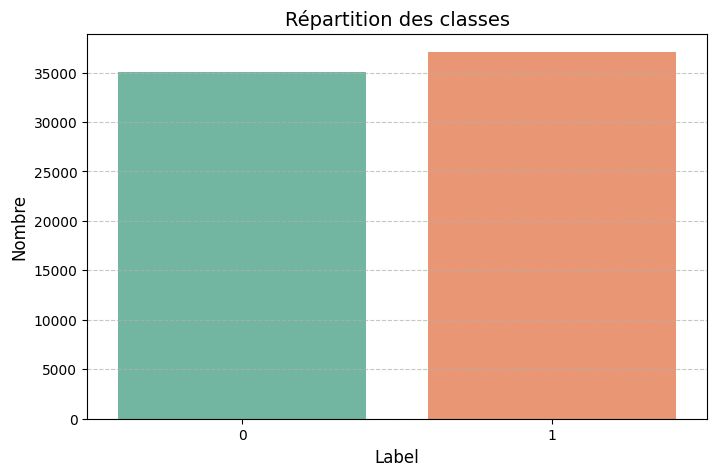

In [14]:
plt.figure(figsize=(8, 5))
sns.countplot(x='label', data=data, palette='Set2')
plt.title('Répartition des classes', fontsize=14)
plt.xlabel('Label', fontsize=12)
plt.ylabel('Nombre', fontsize=12)
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.savefig('distribution_label.png')
plt.show()

In [15]:
data.label.value_counts()

label
1    37067
0    35028
Name: count, dtype: int64

# Tokenisation et padding

In [16]:

max_words = 5000
max_len = 200
tokenizer = Tokenizer(num_words=max_words)
tokenizer.fit_on_texts(data['text'])
sequences = tokenizer.texts_to_sequences(data['text'])
padded_sequences = pad_sequences(sequences, maxlen=max_len, padding='post', truncating='post')



# Division des données

In [17]:
X_train, X_test, y_train, y_test = train_test_split(padded_sequences, data['label'], test_size=0.2, random_state=42)

# Construction du modèle

In [18]:
model = Sequential([
    Embedding(max_words, 100, input_length=max_len),
    SpatialDropout1D(0.2),
    LSTM(100, dropout=0.2, recurrent_dropout=0.2),
    Dense(1, activation='sigmoid')
])
model.compile(
    loss='binary_crossentropy',
    optimizer='adam',
    metrics=[
        BinaryAccuracy(name='accuracy'),
        Precision(name='precision'),
        Recall(name='recall'),
    ]
)
model.build(input_shape=(None, max_len))
model.summary()

/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/embedding.py:90: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ embedding (Embedding)                │ (None, 200, 100)            │         500,000 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ spatial_dropout1d (SpatialDropout1D) │ (None, 200, 100)            │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ lstm (LSTM)                          │ (None, 100)                 │          80,400 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (None, 1)                   │             101 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 580,501 (2.21 MB)

 Trainable params: 580,501 (2.21 MB)

 Non-trainable params: 0 (0.00 B)

# Entraînement

In [19]:
early_stopping = EarlyStopping(
                monitor='val_loss', 
                patience=3, 
                restore_best_weights=True
            )

history = model.fit(
    X_train, y_train, 
    epochs=5, 
    batch_size=64, 
    validation_data=(X_test, y_test), 
    callbacks=[early_stopping]
)

Epoch 1/5
902/902 ━━━━━━━━━━━━━━━━━━━━ 220s 239ms/step - accuracy: 0.7211 - loss: 0.5407 - precision: 0.7212 - recall: 0.7560 - val_accuracy: 0.8511 - val_loss: 0.3690 - val_precision: 0.9039 - val_recall: 0.7947
Epoch 2/5
902/902 ━━━━━━━━━━━━━━━━━━━━ 211s 234ms/step - accuracy: 0.8617 - loss: 0.3531 - precision: 0.8663 - recall: 0.8648 - val_accuracy: 0.9094 - val_loss: 0.2694 - val_precision: 0.8967 - val_recall: 0.9308
Epoch 3/5
902/902 ━━━━━━━━━━━━━━━━━━━━ 214s 237ms/step - accuracy: 0.9199 - loss: 0.2235 - precision: 0.9154 - recall: 0.9304 - val_accuracy: 0.9424 - val_loss: 0.1560 - val_precision: 0.9374 - val_recall: 0.9514
Epoch 4/5
902/902 ━━━━━━━━━━━━━━━━━━━━ 205s 228ms/step - accuracy: 0.9499 - loss: 0.1389 - precision: 0.9458 - recall: 0.9574 - val_accuracy: 0.9512 - val_loss: 0.1295 - val_precision: 0.9442 - val_recall: 0.9618
Epoch 5/5
902/902 ━━━━━━━━━━━━━━━━━━━━ 206s 228ms/step - accuracy: 0.9615 - loss: 0.1072 - precision: 0.9579 - recall: 0.9677 - val_accuracy: 0.9552

# Visualiser l'architecture et sauvegarder le diagramme

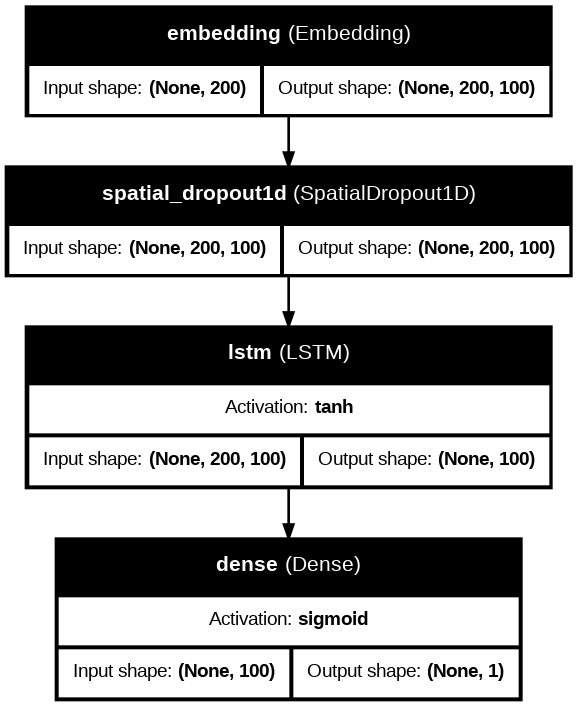

In [20]:
plot_model(
    model,
    to_file='model_architecture.png',
    show_shapes=True,          # Affiche les formes des tenseurs (e.g., (None, 200, 100))
    show_layer_names=True,     # Affiche les noms des couches
    show_dtype=False,          # Ne pas afficher les types de données
    show_layer_activations=True,  # Affiche les fonctions d'activation
    dpi=96                    # Résolution de l'image
)

from IPython.display import Image
Image('model_architecture.png')

# Métriques de performance

In [21]:

from sklearn.metrics import accuracy_score, precision_recall_fscore_support, confusion_matrix

y_pred = (model.predict(X_test) > 0.5).astype("int32")
accuracy = accuracy_score(y_test, y_pred)
precision, recall, f1, _ = precision_recall_fscore_support(y_test, y_pred, average='binary')

print(f"Accuracy: {accuracy:.4f}")
print(f"Precision: {precision:.4f}")
print(f"Recall: {recall:.4f}")
print(f"F1-Score: {f1:.4f}")




451/451 ━━━━━━━━━━━━━━━━━━━━ 21s 45ms/step
Accuracy: 0.9552
Precision: 0.9506
Recall: 0.9629
F1-Score: 0.9567


# Matrice de confusion

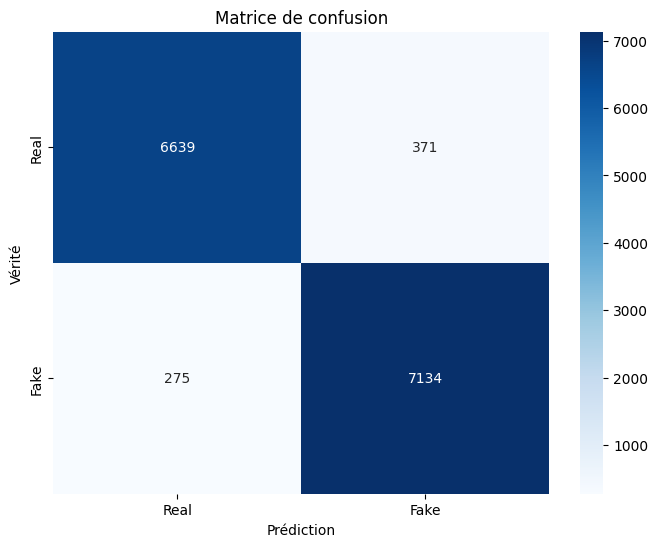

In [22]:
cm = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=['Real', 'Fake'], yticklabels=['Real', 'Fake'])
plt.title('Matrice de confusion')
plt.xlabel('Prédiction')
plt.ylabel('Vérité')
plt.savefig('confusion_matrix.png')
plt.show()

# Visualisation de l'entraînement

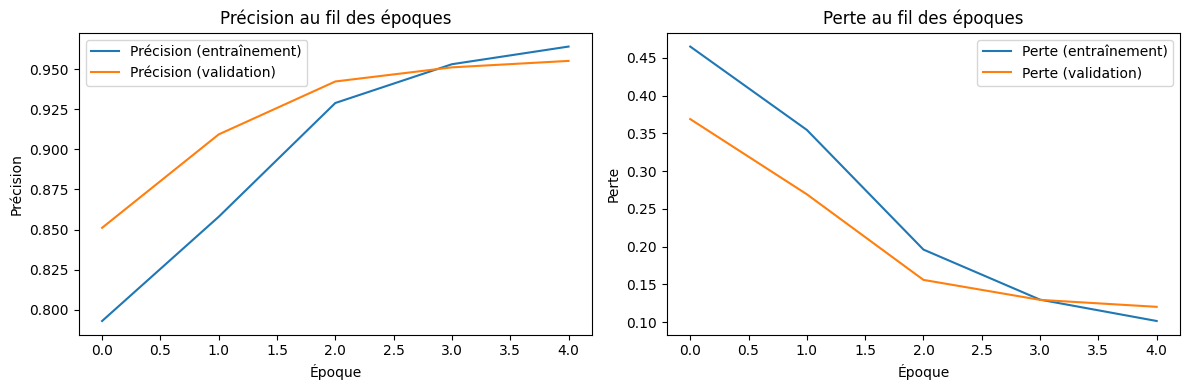

In [23]:

plt.figure(figsize=(12, 4))

# Précision
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='Précision (entraînement)')
plt.plot(history.history['val_accuracy'], label='Précision (validation)')
plt.title('Précision au fil des époques')
plt.xlabel('Époque')
plt.ylabel('Précision')
plt.legend()

# Perte
plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='Perte (entraînement)')
plt.plot(history.history['val_loss'], label='Perte (validation)')
plt.title('Perte au fil des époques')
plt.xlabel('Époque')
plt.ylabel('Perte')
plt.legend()

plt.tight_layout()
plt.savefig('training_history.png')
plt.show()

# Sauvegarder au format HDF5

In [24]:

import pickle

model.save('lstm-last-5.h5') 



with open('tokenizer-last-5.pickle', 'wb') as handle:
    pickle.dump(tokenizer, handle, protocol=pickle.HIGHEST_PROTOCOL)
